# Programming Assignment

### 1. Libraries

In [1]:
import networkx as nx
from IPython.display import Image, display
import json
from graphviz import Digraph
from networkx.algorithms.minors import quotient_graph
import string
from itertools import cycle



### 2. Read the input and check for a valid regex

### 3. Preprocessing 
<P>check operators error</P>
<P>Add concatenation character</P>


In [2]:

CONCAT_SYMBOL = "#"

def validate_regex(regex_pattern):
    if not regex_pattern:
        raise ValueError('Empty regex pattern')
    
    if regex_pattern.count('(') != regex_pattern.count(')'):
        raise ValueError('Mismatched parentheses')
    
    if regex_pattern.count('[') != regex_pattern.count(']'):
        raise ValueError('Mismatched parentheses')
    
    i = 0
    while i < len(regex_pattern):
        if regex_pattern[i] == '[':
            i += 1
            while i < len(regex_pattern) and regex_pattern[i] != ']':
                if regex_pattern[i] == '-':
                    if i == 0 or i == len(regex_pattern) - 1 or regex_pattern[i - 1] == '^' or regex_pattern[i + 1] == ']':
                        raise ValueError('Invalid range in square brackets')
                i += 1
            if i == len(regex_pattern):
                raise ValueError('Mismatched parentheses')
        i += 1
    
    return True


def insert_concat_symbol(regex):
    result = ""
    operators = ["?", "*", "|", "+"]
    inside_brackets = False
    for i in range(len(regex)):
        if regex[i] == "[":
            inside_brackets = True
        elif regex[i] == "]":
            inside_brackets = False

        if (
            not inside_brackets
            and i < len(regex) - 1
            and regex[i + 1] not in operators
            and regex[i] != "|"
            and regex[i] != "("
            and regex[i + 1] != ")"
            and regex[i] != "["
            and regex[i + 1] != "]"
        ):
            result += regex[i] + CONCAT_SYMBOL
        else:
            result += regex[i]      
    return result

def check_operator_error(regex):
    operators = "?*+"
    for i, char in enumerate(regex):
        if char in operators + "|"  :
            if i < len(regex) - 1 and regex[i+1] in operators: 
                raise ValueError('Mismatched operators')

            if char == '|' and not (i > 0 and i < len(regex) - 1):
                raise ValueError('Mismatched | operator')
                
            if char in operators and not i > 0:
                raise ValueError('Mismatched operator')
            

def preprocess_regex(regex):
    validate_regex(regex)
    check_operator_error(regex)
    new_regex = insert_concat_symbol(regex)        
    return new_regex    

### 4. Shunting yard algorithm 
<P>Convert infix regex to postfix regex</P>

In [3]:
def shunting_yard(input_regex):
    """
        * : 0 or more repetition
        + : 1 or more repetition
        # : concatenation
        . : Any single character
        | : OR
        ? : Optional
    """
    
    precedence = {
    '*': 6,  # 0 or more repetition
    '+': 5,  # 1 or more repetition
    '?': 4,  # optional (exists or not)
    '#': 3,  # concatenation operator
    '.': 2,  # any single character
    '|': 1   # OR operator
    }
    
    postfix_output = []
    operator_stack = []
    alphanumeric = string.ascii_letters + string.digits
    inside_bracket_ranges = False

    i = 0
    while i < len(input_regex):
        char = input_regex[i]

        if char == '[':
            start = i
            while i < len(input_regex) and input_regex[i] != ']':
                i += 1
            if i < len(input_regex):
                postfix_output.append(input_regex[start:i+1]) 
                i += 1
            continue

        if char == '(':
            operator_stack.append(char)
        elif char == ')':
            while operator_stack and operator_stack[-1] != '(':
                postfix_output.append(operator_stack.pop())
            if not operator_stack:
                raise ValueError('Mismatched closing parenthesis')
            operator_stack.pop()  
        elif char in precedence:
            while operator_stack and operator_stack[-1] in precedence and precedence[char] <= precedence[operator_stack[-1]]:
                postfix_output.append(operator_stack.pop())
            operator_stack.append(char)  
        else:
            postfix_output.append(char)
        i += 1

    while operator_stack:
        if operator_stack[-1] == '(':
            raise ValueError('Mismatched openning parenthesis')
            return None
        elif operator_stack[-1] == '[':
            raise ValueError('Mismatched openning square bracket')
            return None
        postfix_output.append(operator_stack.pop())

    return ''.join(postfix_output)


### 5. Convert postfix regex to NFA using thomson's rule

In [4]:
global state_counter
state_counter = 0

def graph_to_json(G):
    """
    Convert a graph to a JSON structure, supporting multiple transitions for the same input symbol,
    with states and transitions sorted. Assume the starting state is the minimum one
    and the terminating state is the maximum one.
    """
    nodes_sorted = sorted(G.nodes(), key=lambda x: (isinstance(x, int), x))
    starting_state = str(nodes_sorted[0])
    terminating_states = [] 

    for node, data in G.nodes(data=True):
        if node == nodes_sorted[-1] or (data and data['is_terminating']):
            terminating_states.append(str(node))

    graph_dict = {"startingState": f"S{starting_state}"}
    
    for node in sorted(G.nodes(), key=lambda x: (isinstance(x, int), x)):
        node_entry = {"isTerminatingState": str(node) in terminating_states}
        
        transitions = {}
        for edge in sorted(G.out_edges(node, data=True), key=lambda e: e[2]['symbol']):
            symbol, target_state = edge[2]['symbol'], edge[1]
            if symbol in transitions:
                transitions[symbol] = transitions[symbol] if isinstance(transitions[symbol], list) else [transitions[symbol]]
                transitions[symbol].append(str(f"S{target_state}"))
            else:
                transitions[symbol] = str(f"S{target_state}")
        
        node_entry.update({symbol: target if isinstance(target, list) and len(target) > 1 else target[0] if isinstance(target, list) else target 
                        for symbol, target in sorted(transitions.items(), key=lambda item: item[0])})
        
        graph_dict[str(f"S{node}")] = node_entry

    return json.dumps(graph_dict, indent=2, ensure_ascii=False)

def draw_graph(G, filename):
    colors = [
        '3A86FF', 
        '8338EC',  
        'FF006E',  
        'FB5607', 
        'FFBE0B',  
    ]

    color_cycle = cycle(colors)

    node_colors = {node: next(color_cycle) for node in G.nodes()}

    if G.nodes():
        start_state = min(G.nodes, key=lambda x: (isinstance(x, int), x))
        end_state = max(G.nodes, key=lambda x: (isinstance(x, int), x))
    else:
        start_state, end_state = None, None

    dot = Digraph(graph_attr={
        'rankdir': 'LR',
        'label': filename,
        'fontsize': '20'
    })

    for node, data in G.nodes(data=True):
        shape = 'doublecircle' if node == end_state or (data and data['is_terminating']) else 'circle'
        label = 'start' if node == 0 else f"S{node}"
        color = 'grey' if node == start_state else f"#{node_colors[node]}"
        dot.node(str(f"S{node}"), label, color='black', fillcolor=color, style='filled', shape=shape)

    for u, v, d in G.edges(data=True):
        dot.edge(str(f"S{u}"), str(f"S{v}"), label=d['symbol'])

    dot.render(filename, format='png', view=True)

    return filename


def increment_nfa_states_by_one(nfa):
    """
    Increments the state (label) of each node in the NFA by 1, including updating the start and end states.
    """
    G, start_state, end_state = nfa

    if G.number_of_nodes() == 0:
        return nfa  

    mapping = {node: node + 1 for node in G.nodes() if isinstance(node, int)}

    new_start_state = mapping.get(start_state, start_state)
    new_end_state = mapping.get(end_state, end_state)

    G_relabelled = nx.relabel_nodes(G, mapping, copy=True)

    return G_relabelled, new_start_state, new_end_state

def create_basic_nfa(symbol):

    global state_counter

    g = nx.MultiDiGraph()
    start_state = state_counter
    state_counter += 1
    end_state = state_counter
    state_counter += 1
    g.add_node(start_state)
    g.add_node(end_state)
    g.add_edge(start_state, end_state, symbol=symbol)

    return g, start_state, end_state

def concatenate(nfa1, nfa2):
    """
    Concatenates two NFAs by connecting the NFA with the minimum maximum state 
    to the one with the maximum minimum state with an ε-transition.
    """
    g1, start1, end1 = nfa1
    g2, start2, end2 = nfa2

    g = nx.union(g1, g2, rename=(None, None))

    max_state_nfa1 = max(g1.nodes())
    min_state_nfa2 = min(g2.nodes())

    if max_state_nfa1 < min_state_nfa2:
        g.add_edge(max_state_nfa1, min_state_nfa2, symbol='ε')
        start_state, end_state = start1, end2
    else:
        g.add_edge(min_state_nfa2, max_state_nfa1, symbol='ε')
        start_state, end_state = start2, end1

    return g, start_state, end_state

def alternate(nfa1, nfa2):

    global state_counter

    new_1 = increment_nfa_states_by_one(nfa1)
    new_2 = increment_nfa_states_by_one(nfa2)
    g = nx.union(new_1[0], new_2[0], rename=(None, None))
    
    max_1 = max(new_1[0].nodes)
    max_2 = max(new_2[0].nodes)
    min_1 = min(new_1[0].nodes)
    min_2 = min(new_2[0].nodes)

    max_total = max(max_1,max_2)
    min_total = min(min_1,min_2)

    start_state = min_total -1
    end_state = max_total + 1
    state_counter = end_state + 1

    g.add_node(start_state)
    g.add_node(end_state)

    g.add_edge(start_state, new_1[1], symbol='ε')
    g.add_edge(start_state, new_2[1], symbol='ε')

    g.add_edge(new_1[2], end_state, symbol='ε')
    g.add_edge(new_2[2], end_state, symbol='ε')

    return g, start_state, end_state

def kleene_star(nfa):
    """
    Creates an NFA representing the Kleene star operation.
    """

    global state_counter
    new_nfa = increment_nfa_states_by_one(nfa)

    g, start_state, end_state = new_nfa
    new_g = nx.MultiDiGraph(g)  
    new_start = min(g.nodes) - 1  
    new_end = max(g.nodes) + 1  

    new_g.add_node(new_start)
    new_g.add_node(new_end)

    new_g.add_edge(new_start, start_state, symbol='ε')  # Start to old start
    new_g.add_edge(end_state, new_end, symbol='ε')  # Old end to new end
    new_g.add_edge(end_state, start_state, symbol='ε')  # Loop back to start
    new_g.add_edge(new_start, new_end, symbol='ε')  # Directly skip the NFA

    state_counter += 2

    return new_g, new_start, new_end


def kleene_plus(nfa):
    """
    Creates an NFA representing the Kleene plus operation.
    """
    global state_counter
    new_nfa = increment_nfa_states_by_one(nfa)

    g, start_state, end_state = new_nfa
    new_g = nx.MultiDiGraph(g)  
    new_start = min(g.nodes) - 1  
    new_end = max(g.nodes) + 1  

    new_g.add_node(new_start)
    new_g.add_node(new_end)

    new_g.add_edge(new_start, start_state, symbol='ε')  # Start to old start
    new_g.add_edge(end_state, new_end, symbol='ε')  # Old end to new end
    new_g.add_edge(end_state, start_state, symbol='ε')  # Loop back to start

    state_counter += 2

    return new_g, new_start, new_end

def optional_operator(nfa):
    """
    Creates an NFA representing the optional operation (? operator),
    allowing zero or one occurrence of the NFA.
    """

    global state_counter
    new_nfa = increment_nfa_states_by_one(nfa)

    g, start_state, end_state = new_nfa
    new_g = nx.MultiDiGraph(g)
    new_start = min(g.nodes) - 1
    new_end = max(g.nodes) + 1

    new_g.add_node(new_start)
    new_g.add_node(new_end)

    new_g.add_edge(new_start, start_state, symbol='ε')  # Start to old start
    new_g.add_edge(end_state, new_end, symbol='ε')  # Old end to new end
    new_g.add_edge(new_start, new_end, symbol='ε')  # Directly skip the NFA

    state_counter += 2

    return new_g, new_start, new_end

def postfix_to_nfa(postfix):
    """
    Converts postfix regex to NFA using Thomson's algorithm.
    """
    stack = []
    i = 0
    while i < len(postfix):
        char = postfix[i]
    
        if char == '[':
            # Start capturing the bracket expression
            bracket_expression = char
            i += 1
            while i < len(postfix) and postfix[i] != ']':
                bracket_expression += postfix[i]
                i += 1
            if i < len(postfix) and postfix[i] == ']':
                bracket_expression += ']'
            nfa = create_basic_nfa(bracket_expression)
            stack.append(nfa)
        elif char in ['*', '|', '#', '+', '?']:
            if char == '*':  # Kleene star
                nfa = kleene_star(stack.pop())
                stack.append(nfa)
            elif char == '|':  # Alternation
                nfa2 = stack.pop()
                nfa1 = stack.pop()
                nfa = alternate(nfa1, nfa2)
                stack.append(nfa)
            elif char == '#':  # Concatenation
                nfa2 = stack.pop()
                nfa1 = stack.pop()
                nfa = concatenate(nfa1, nfa2)
                stack.append(nfa)
            elif char == '+':
                nfa = kleene_plus(stack.pop())
                stack.append(nfa)
            elif char == '?':
                nfa = optional_operator(stack.pop())
                stack.append(nfa)

        else:
            nfa = create_basic_nfa(char)
            stack.append(nfa)
        i += 1

    return stack.pop()


### 6. Convert NFA to DFA using subset construction 


In [5]:
def nfa_to_dfa_graph(nfa):
    def compute_epsilon_closure(state):
        stack = [state]
        closure = set([state])
        while stack:
            current = stack.pop()
            if "ε" in nfa[current]:
                epsilon_states = nfa[current]["ε"]
                if not isinstance(epsilon_states, list):
                    epsilon_states = [epsilon_states]
                for eps_state in epsilon_states:
                    if eps_state not in closure:
                        closure.add(eps_state)
                        stack.append(eps_state)
        return closure

    def find_transitions(state_set, input_symbol):
        transition_states = set()
        for state in state_set:
            if input_symbol in nfa[state]:
                next_state = nfa[state][input_symbol]
                if isinstance(next_state, list):
                    transition_states.update(next_state)
                else:
                    transition_states.add(next_state)
        final_states = set()
        for state in transition_states:
            final_states.update(compute_epsilon_closure(state))
        return final_states
    
    inputs = {key for state in nfa if state != "startingState" for key in nfa[state] if key not in ["ε", "isTerminatingState"]}
    initial_state = compute_epsilon_closure(nfa["startingState"])
    dfa_states = {frozenset(initial_state): '0'}
    dfa_transitions = {}
    state_names_count = 0
    state_queue = [initial_state]

    while state_queue:
        current_state = state_queue.pop(0)
        current_state_name = dfa_states[frozenset(current_state)]
        dfa_transitions[current_state_name] = {}
        
        for input_symbol in inputs:
            result_state = find_transitions(current_state, input_symbol)
            if result_state:
                if frozenset(result_state) not in dfa_states:
                    state_names_count += 1
                    dfa_states[frozenset(result_state)] = str(state_names_count)
                    state_queue.append(result_state)
                dfa_transitions[current_state_name][input_symbol] = dfa_states[frozenset(result_state)]
        
    dfa_terminating_states = {state_name for state_set, state_name in dfa_states.items() if any(nfa[state].get('isTerminatingState', False) for state in state_set)}

    G = nx.MultiDiGraph()

    for state_set, state_name in dfa_states.items():
        if state_name in dfa_terminating_states:
            G.add_node(state_name, is_terminating=True)
        else:
            G.add_node(state_name, is_terminating=False)

    for state, transitions in dfa_transitions.items():
        for input_symbol, target_state in transitions.items():
            G.add_edge(state, target_state, label=input_symbol, symbol = input_symbol)
                

    return G

### 7. Convert to minimized DFA

In [6]:
def minimize_dfa(dfa_graph):
    def find_partition(state, partitions):
        for index, partition in enumerate(partitions):
            if state in partition:
                return index
        return None  # Should not happen

    accepting = {node for node, data in dfa_graph.nodes(data=True) if data['is_terminating']}
    non_accepting = set(dfa_graph.nodes) - accepting
    partitions = [non_accepting, accepting] if non_accepting else [accepting]

    refined = True
    while refined:
        refined = False
        new_partitions = []
        for partition in partitions:
            subgraph = dfa_graph.subgraph(partition)
            behavior_map = {}
            for state in subgraph:
                transitions = tuple(
                    (dfa_graph.edges[state, target, key]['label'], find_partition(target, partitions))
                    for target, keydict in dfa_graph[state].items()
                    for key in keydict
                )
                if transitions not in behavior_map:
                    behavior_map[transitions] = []
                behavior_map[transitions].append(state)
            if len(behavior_map) > 1:
                refined = True
            new_partitions.extend(behavior_map.values())

        partitions = new_partitions

    minimized_dfa = nx.MultiDiGraph()
    added_transitions = set()

    for i, partition in enumerate(partitions):
        is_accepting = any(state in accepting for state in partition)
        minimized_dfa.add_node(i, is_terminating=is_accepting)

    for partition in partitions:
        representative = next(iter(partition))  
        source_part = find_partition(representative, partitions)
        for target, keydict in dfa_graph[representative].items():
            for key in keydict:
                target_part = find_partition(target, partitions)
                label = dfa_graph.edges[representative, target, key]['label']
                transition = (source_part, label, target_part)
                if transition not in added_transitions:
                    minimized_dfa.add_edge(source_part, target_part, label=label, symbol=label)
                    added_transitions.add(transition)

    return minimized_dfa

### Program

preprocessed:  a#b#c
postfix_regex:  ab#c#



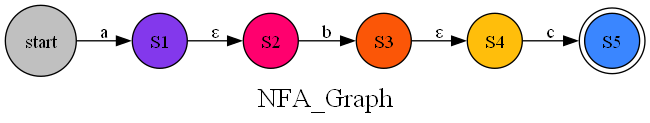

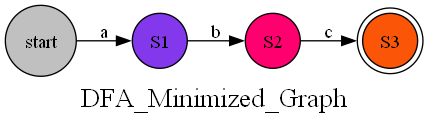

In [7]:
state_counter = 0

def main(input):

  input_regex = input

  preprocessed = preprocess_regex(input_regex)
  print("preprocessed: ",preprocessed)
  postfix_regex = shunting_yard(preprocessed)
  print("postfix_regex: ", postfix_regex)

  nfa = postfix_to_nfa(postfix_regex)
  nfa_image_file = draw_graph(nfa[0], 'NFA_Graph')
  nfa_json_output = graph_to_json(nfa[0])

  with open("NFA_Output", "w") as file:
      file.write(nfa_json_output)

  nfa_json_data = None
  with open("NFA_Output", "r") as file:
      nfa_json_data = json.load(file)

  dfa_graph = nfa_to_dfa_graph(nfa_json_data)
  minimized_dfa = minimize_dfa(dfa_graph)
  minimized_dfa_image_file = draw_graph(minimized_dfa, 'DFA_Minimized_Graph')
  minimized_dfa_json_output = graph_to_json(minimized_dfa)

  with open("DFA_Minimized_Output", "w") as file:
      file.write(minimized_dfa_json_output)

  print("")
  display(Image(filename=f'{nfa_image_file}.png'))
  print("")
  display(Image(filename=f'{minimized_dfa_image_file}.png'))


# Read Input
input_regex = "abc"
main(input_regex)

